# In the following calculations we assume
-  GEO orbit height = 35800 km
-  Earth radius = 6400

## 1.1 Maximum spatial error in position on Earth surface if UTC is used instead of UT1

$dx = d\alpha\cdot R = w \cdot dt \cdot R$

In [1]:
print("Answer:", "{:.2f}".format(0.9 * 2 * 3.1415/ (24 * 60 * 60) * 6400), "km")

Answer: 0.42 km


## 1.2 Calculate period of satellite X1 on near circular orbit with altitude 500 km

In [3]:
print("Answer:","{:.2f}".format( 24 * (((500 + 6400)/(35800 + 6400))**3)**(0.5)), "hours")

Answer: 1.59 hours


## 1.3 Calculate mean velocity of the satellite X1 and mean velocity of its subsatellite point

Circular orbit speed $v = \sqrt{GM/r}$

In [3]:
import numpy as np
print("Answer:", "{:.1f}".format(np.sqrt(6.67408 * 10 **(-11) * 5.972 * 10 ** (24) / (500 + 6400) * 10 **(-3))), "m/s")

Answer: 7600.3 m/s


In [4]:
print("Answer:", "{:.1f}".format(2 * 3.1415 * (500 + 6400) * 10 **(3) / (1.5867 * 60 * 60)), "m/s")

Answer: 7589.6 m/s


Subsatellite point speed $v_2 = 2\cdot pi \cdot R / T$

In [5]:
print("Answer:", "{:.1f}".format(2 * 3.1415 * (6400) * 10 **(3) / (1.5867 * 60 * 60)), "m/s")

Answer: 7039.6 m/s


## 1.4 Calculate longitudinal distance (km) between two successive ground tracks for X1
-  At equator
-  at 55d. latitude

$x = w_{earth} \cdot T \cdot
R$

For equator:

In [6]:
print("Answer:", "{:.1f}".format(2 * 3.1415/ (24 * 60 * 60) *  (1.5867 * 60 * 60) * 6400), "km")

Answer: 2658.5 km


For 55d. latitude its effective radius is $R\cdot cos(55^{\circ})$:

In [7]:
import math
print("Answer:", "{:.1f}".format(2 * 3.1415/ (24 * 60 * 60) *  (1.5867 * 60 * 60) * 6400 * math.cos(55/180*3.1415)), "km")

Answer: 1524.9 km


## 1.5 How many imaging GEO satellites are required to cover Earth without gaps in equatorial belt? 

In [8]:
number = 2 * math.pi/(2 * math.acos(6400/(35800 + 6400)))
print("{:.1f}".format(number))

2.2


With an ideal optical equipment we need at least **3** satellites to observe all equator

# PART2

- Fetch and use a fresh TLE from www.celestrak.com
- Ground station and imaging target are located at  55N.latitude, 37 E.longitude unless specified otherwise
- Reference or start of scenario time is  2019-01-30T00:00:00UTC

Chosen satellite: **RADARSAT-2**

## 2.1 Calculate satellite position at reference time (Cartesian (lat, lon, alt), topocentric (az, el, range))

Data from https://www.celestrak.com/satcat/tle.php?CATNR=32382

In [9]:
line_1 = '1 32382U 07061A   19034.82262823 -.00000035  00000-0  32430-5 0  9998'
line_2 = '2 32382  98.5766  43.7002 0001147  90.4325  27.8262 14.29985431581561'

In [10]:
from pyorbital.orbital import Orbital
import datetime
from pyorbital import tlefile

In [11]:
sat = Orbital(satellite='RADARSAT-2', line1 = line_1, line2 = line_2)

reference_time = datetime.datetime.strptime('2019-01-30 00:00:00', '%Y-%m-%d %H:%M:%S')

station_lon = 37
station_lat = 55
station_alt = 0

In [12]:
# Normalized cartesian coordinates (pos_x, pos_y, pos_z), (vel_x, vel_y, vel_z)
R = 6400
print ("X: ", "{:.1f}".format(sat.get_position(reference_time, normalize = False)[0][0]), "km")
print ("Y: ", "{:.1f}".format(sat.get_position(reference_time, normalize = False)[0][1]), "km")
print ("Z: ", "{:.1f}".format(sat.get_position(reference_time, normalize = False)[0][2]), "km")

X:  -4238.5 km
Y:  -4197.1 km
Z:  3973.4 km


In [13]:
sat.get_position(reference_time)

(array([-0.66453015, -0.65804698,  0.62296567]),
 array([-0.03609462, -0.01805126, -0.0574037 ]))

In [14]:
# Get longitude, latitude and altitude of the satellite:
sat_lon, sat_lat, sat_alt = sat.get_lonlatalt(reference_time)

print ("Longitude: ", "{:.1f}".format(sat_lon), "°")
print ("Latitude: ", "{:.1f}".format(sat_lat), "°")
print ("Altitude: ", "{:.1f}".format(sat_alt), "km")

Longitude:  95.8 °
Latitude:  33.8 °
Altitude:  795.6 km


Next function is a local copy of the function from https://github.com/pytroll/pyorbital/blob/master/pyorbital/orbital.py with modified output (range was added)

In [15]:
# Get azimuth, elevation and range
az, el = sat.get_observer_look(utc_time = reference_time,
                      lon = station_lon,
                      lat = station_lat,
                      alt = station_alt)
print ("Azimuth: ", "{:.1f}".format(az), "°")
print ("Elevation: ", "{:.1f}".format(el), "°")

Azimuth:  92.6 °
Elevation:  -14.7 °


## 2.2 Calculate AOS/LOS events for first contact with the ground station (min elevation level 10 degrees)

In [16]:
# Custom procedure to find first AOS and LOS times
def find_aos_los_time (satellite, observer_lon, observer_lat, observer_alt, start_time, el_threshold):
    temp_time = start_time
    el_der = 0
    _, el_prev = sat.get_observer_look(utc_time = start_time,
                                          lon = observer_lon,
                                          lat = observer_lat,
                                          alt = observer_alt)
    i = 0
    while i < 2:
        temp_time += datetime.timedelta(seconds=1)
        _, el= sat.get_observer_look(utc_time = temp_time,
                                         lon = observer_lon,
                                         lat = observer_lat,
                                         alt = observer_alt)
#         print(el)
        el_der = el - el_prev
        if (el_der > 0 and el > el_threshold and el_prev < el_threshold):
            aos_time = temp_time;
            i+=1
        if (el_der < 0 and el < el_threshold and el_prev > el_threshold):
            los_time = temp_time; 
            i+=1
        el_prev = el
    return aos_time, los_time

In [17]:
aos_time, los_time = find_aos_los_time (satellite = sat, 
                                        observer_lon = station_lon, 
                                        observer_lat = station_lat, 
                                        observer_alt = station_alt, 
                                        start_time = reference_time, 
                                        el_threshold = 10)
print("Custom procedure:\n")
print("AOS time:", aos_time.strftime('%Y-%m-%d %H:%M:%S'))
print("LOS time:", los_time.strftime('%Y-%m-%d %H:%M:%S'))

Custom procedure:

AOS time: 2019-01-30 03:11:18
LOS time: 2019-01-30 03:20:34


## 2.3 Calculate first pass culmination event time and culmination elevation

In [18]:
data = sat.get_next_passes(reference_time, 4, station_lon, station_lat, station_alt, tol=0.001, horizon=10)

print("Pyorbital procedure:\n")
print("AOS time:", data[0][0].strftime('%Y-%m-%d %H:%M:%S'))
print("LOS time:", data[0][1].strftime('%Y-%m-%d %H:%M:%S'), "\n")
print("First culmination time:", data[0][2].strftime('%Y-%m-%d %H:%M:%S'))

_, el_culm = sat.get_observer_look(utc_time = data[0][2],
                      lon = station_lon,
                      lat = station_lat,
                      alt = station_alt)
print("Culmination elevation:", "{:.2f}".format(el_culm), "°")

Pyorbital procedure:

AOS time: 2019-01-30 03:11:17
LOS time: 2019-01-30 03:20:33 

First culmination time: 2019-01-30 03:15:56
Culmination elevation: 31.29 °


## 2.4 Calculate first 5 imaging events schedule for the target. Imaging incidence angle < 30 degrees

Imaging incidence angle < 30 degrees $\Leftrightarrow$ Culmination elevation **> 60** degrees. Specified station is considered to be a target.

In [19]:
data = sat.get_next_passes(reference_time, 110, station_lon, station_lat, station_alt, tol=0.001, horizon=60)

j = 0
for event in data:
    # Calculate elevation angle at culmination point
    _, el_culm = sat.get_observer_look(utc_time = data[0][2],
                      lon = station_lon,
                      lat = station_lat,
                      alt = station_alt)
    if (el_culm > 60):
        j += 1
        print("Imaging event:", j)
        print("First culmination time:", event[2].strftime('%Y-%m-%d %H:%M:%S'))
        print("Culmination elevation:", "{:.1f}".format(el_culm), "°\n")

Imaging event: 1
First culmination time: 2019-01-30 14:41:39
Culmination elevation: 88.9 °

Imaging event: 2
First culmination time: 2019-01-31 04:26:45
Culmination elevation: 88.9 °

Imaging event: 3
First culmination time: 2019-02-01 03:57:40
Culmination elevation: 88.9 °

Imaging event: 4
First culmination time: 2019-02-02 14:54:06
Culmination elevation: 88.9 °

Imaging event: 5
First culmination time: 2019-02-03 04:39:11
Culmination elevation: 88.9 °



## 2.5 ** Simulate TLE set for a constellation of  4 satellites flying in 4 equally spaced orbital planes. Calculate first 5 imaging events schedule for the simulated constellation

In [20]:
line_1_1 = '1 32382U 07061A   19034.82262823 -.00000035  00000-0  32430-5 0  9998'
line_1_2 = '2 32382  98.5766  43.7002 0001147  90.4325  27.8262 14.29985431581561'

line_2_1 = '1 32382U 07061A   19034.82262823 -.00000035  00000-0  32430-5 0  9998'
line_2_2 = '2 32382  98.5766  133.700 0001147  90.4325  27.8262 14.29985431581569'

line_3_1 = '1 32382U 07061A   19034.82262823 -.00000035  00000-0  32430-5 0  9998'
line_3_2 = '2 32382  98.5766  223.700 0001147  90.4325  27.8262 14.29985431581569'

line_4_1 = '1 32382U 07061A   19034.82262823 -.00000035  00000-0  32430-5 0  9998'
line_4_2 = '2 32382  98.5766  313.700 0001147  90.4325  27.8262 14.29985431581569'

In [21]:
sat_1 = Orbital(satellite='RADARSAT-2', line1 = line_1_1, line2 = line_1_2)
sat_2 = Orbital(satellite='sat 2', line1 = line_2_1, line2 = line_2_2)
sat_3 = Orbital(satellite='sat 3', line1 = line_3_1, line2 = line_3_2)
sat_4 = Orbital(satellite='sat 4', line1 = line_4_1, line2 = line_4_2)

In [22]:
# Function for calculating schedule of imaging for 1 satellite
def get_imaging_schedule(satellite, start_time, target_lon, target_lat, target_alt, hours, elev_threshold_angle):
    data = satellite.get_next_passes(start_time, hours,  target_lon, target_lat, target_alt, 
                               tol=0.001, horizon=elev_threshold_angle)
    schedule = []
    for event in data:
        # Calculate elevation angle at culmination point
        _, el_culm = satellite.get_observer_look(utc_time = data[0][2],
                          lon = station_lon,
                          lat = station_lat,
                          alt = station_alt)
        if (el_culm > elev_threshold_angle):
            schedule.append(event[2])
    return schedule

In [23]:
hours_for_calc = 35
el_angle = 60
schedule = []

schedule = get_imaging_schedule(sat_1, reference_time, 
                                station_lon, station_lat, station_alt, 
                                hours_for_calc, elev_threshold_angle = el_angle)

schedule.extend(get_imaging_schedule(sat_2, reference_time, 
                                     station_lon, station_lat, station_alt, 
                                     hours_for_calc, elev_threshold_angle = el_angle))

schedule.extend(get_imaging_schedule(sat_3, reference_time, 
                                     station_lon, station_lat, station_alt, 
                                     hours_for_calc, elev_threshold_angle = el_angle))

In [24]:
schedule.sort()
print("Schedule:\n")
for i in schedule:
    print(i.strftime('%Y-%m-%d %H:%M:%S'))

Schedule:

2019-01-30 02:56:11
2019-01-30 09:58:43
2019-01-30 14:41:39
2019-01-30 16:41:15
2019-01-31 02:27:08
2019-01-31 04:26:45


# 2.6 *** Select one of provided TLE files with one year coverage and investigate increase of propagation error vs epoch age.  Present results in either tabular or (better) graphical form ( error vs te age)

In [25]:
# with open('flock3m.tle') as f:
#     lines = f.readlines()

In [26]:
# with open('erosb-2018.tle') as f:
#     lines = f.readlines()

In [27]:
with open('terra-2018.tle') as f:
    lines = f.readlines()

In [28]:
length = len(lines)
if length%3 == 0:
    print ("OK")
else:
    print("Wrong number of lines")

OK


In [29]:
import numpy as np

# Update Reference time
reference_time = datetime.datetime.strptime('2019-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

# Allocate memory for results
sat_lon_arr = np.zeros(int(length/3)) 
sat_lat_arr = np.zeros(int(length/3))  
sat_alt_arr = np.zeros(int(length/3)) 

sat_x_arr = np.zeros(int(length/3)) 
sat_y_arr = np.zeros(int(length/3))  
sat_z_arr = np.zeros(int(length/3)) 

days_arr = np.zeros(int(length/3)) 


for i in range(int(length/3)):
    
    # Extracting TLE
    line_1 = lines[3*i + 1];
    line_2 = lines[3*i + 2];
    
    sat = Orbital(satellite='TERRA', line1 = line_1, line2 = line_2)
    
    # Extracting  the day
    temp = line_1
    day = temp.split()[3]
    day = float(day[2:])
    
    # Calc and fill the coordinates
    sat_lon_arr[i], sat_lat_arr[i], sat_alt_arr[i] = sat.get_lonlatalt(reference_time)
    days_arr[i] = day
    
    pos, _ =  sat.get_position(reference_time, normalize = False)
    sat_x_arr[i] = pos[0]
    sat_y_arr[i] = pos[1]
    sat_z_arr[i] = pos[2]
    
# Calc absolute error between all TLEs and last TLE
sat_lon_arr = sat_lon_arr[-1] - sat_lon_arr
sat_lat_arr = sat_lat_arr[-1] - sat_lat_arr
sat_alt_arr = sat_alt_arr[-1] - sat_alt_arr

# Calc norm
distance = np.sqrt((sat_x_arr - sat_x_arr[-1])**2 +
                   (sat_y_arr - sat_y_arr[-1])**2 +
                   (sat_z_arr - sat_z_arr[-1])**2)
# Invert days
days_arr = 365 + 1 - days_arr

In [30]:
import matplotlib.pyplot as plt
import matplotlib

plt.gcf().clear()
figure = plt.figure(figsize=(6.5, 7), dpi=500)
ax_1 = figure.add_subplot(311)
ax_2 = figure.add_subplot(312)
ax_3 = figure.add_subplot(313)

# Plot
ax_1.plot(days_arr, sat_lon_arr, color = "blue")
ax_2.plot(days_arr, sat_lat_arr, color = "red")
ax_3.plot(days_arr, sat_alt_arr, color = "green")

# Set labels, title, legend
ax_1.set_title("Longitude error (relative to the reference point)")
ax_1.set_xlabel("Days")
ax_1.set_ylabel("°")
ax_1.grid(True)

ax_2.set_title("Latitude error (relative to the reference point)")
ax_2.set_xlabel("Days")
ax_2.set_ylabel("°")
ax_2.grid(True)

ax_3.set_title("Altitude error (relative to the reference point)")
ax_3.set_xlabel("Days")
ax_3.set_ylabel("km")
ax_3.grid(True)

matplotlib.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 3250x3500 with 3 Axes>

In [31]:
my_path = "C:\\Users\\Sergey\\OneDrive\\Skoltech\\Remote Sensing\\Task1\\"
# Save a figure
figure.savefig( my_path + 'images\\year_tle_set_1.png', format = 'png', dpi = 1000, pad_inches=0)

<Figure size 432x288 with 0 Axes>

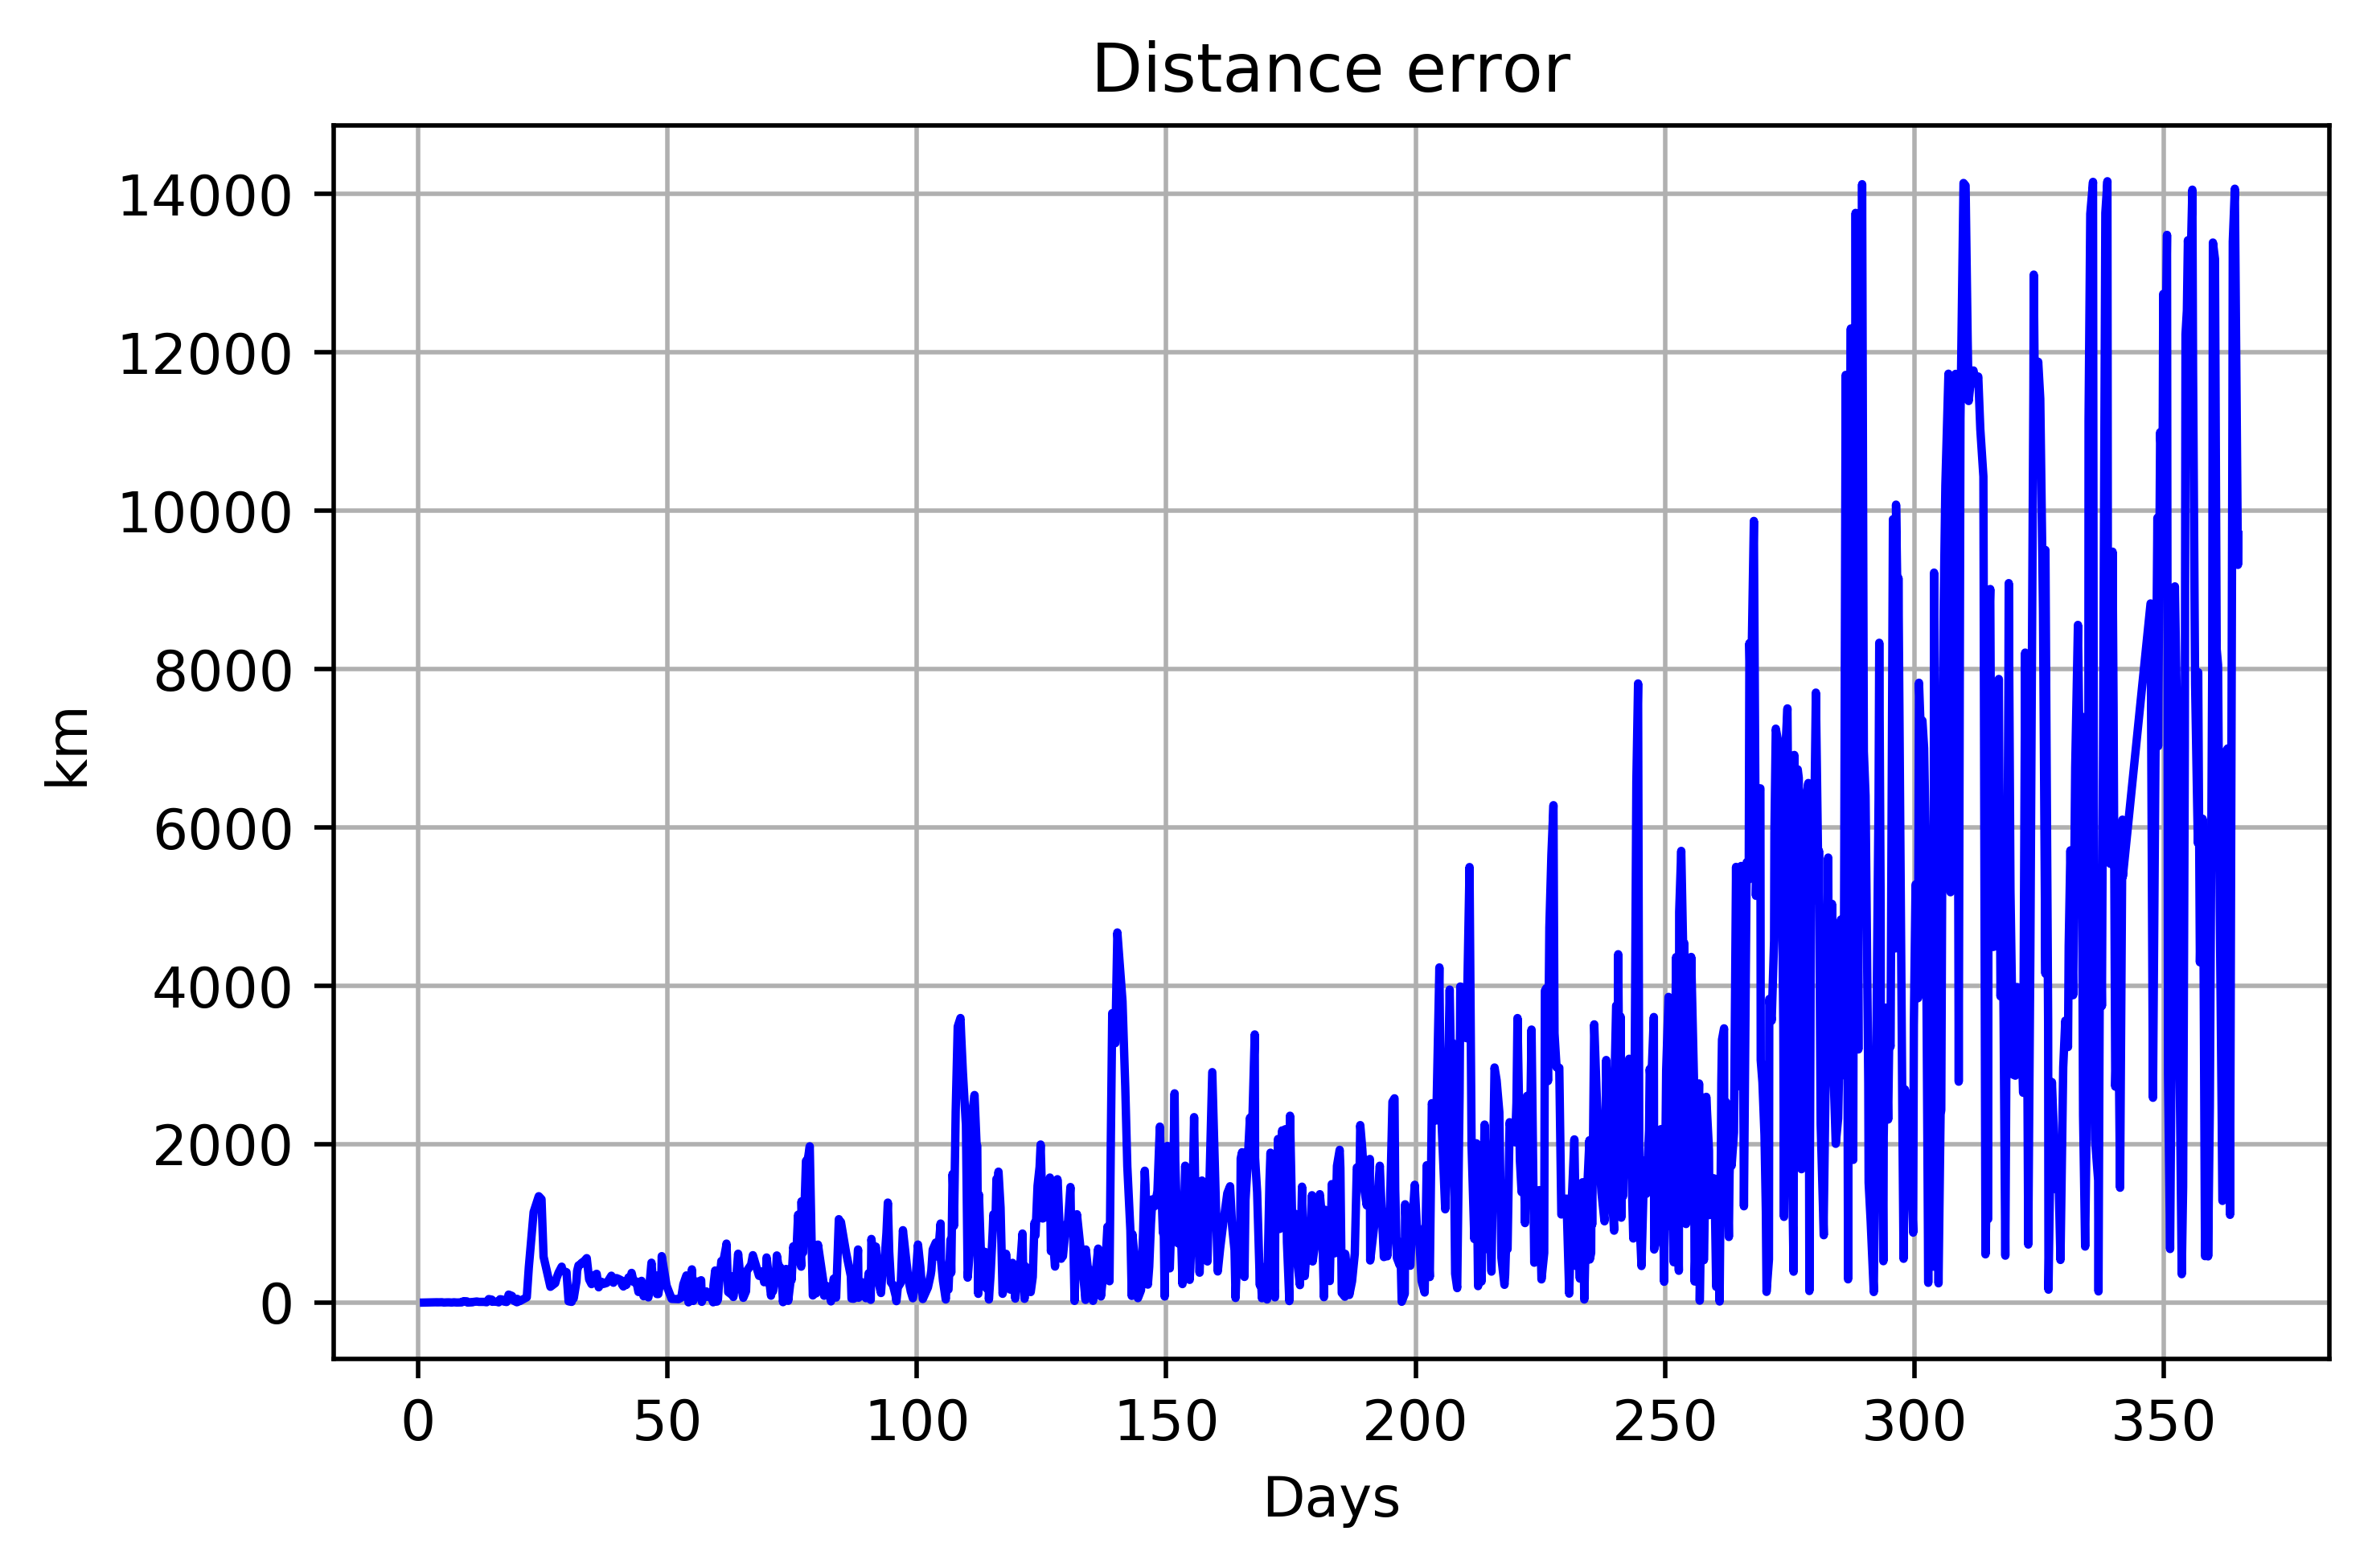

In [32]:
plt.gcf().clear()
figure = plt.figure(figsize=(6, 4), dpi=500)
ax_1 = figure.add_subplot(111)

# Plot
ax_1.plot(days_arr, distance, color = "blue")

# Set labels, title, legend
ax_1.set_title("Distance error")
ax_1.set_xlabel("Days")
ax_1.set_ylabel("km")
ax_1.grid(True)

matplotlib.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

In [33]:
my_path = "C:\\Users\\Sergey\\OneDrive\\Skoltech\\Remote Sensing\\Task1\\"
# Save a figure
figure.savefig( my_path + 'images\\year_tle_set_2.png', format = 'png', dpi = 1000, pad_inches=0)